#  <center> Walmart Product Review Analysis </center>

### Goal
Cuurrently, Walmart's online market promotes clothing products by price range and brand. I do not believe they have a way to analyze customer's reviews and promote items based on customer's "Recommended" score.    

This analysis will look at Walmart clothing reviews to find key features that predict whether a customer will recommend an item or not. This investigation will be conducted using [Natural Language Processing](https://en.wikipedia.org/wiki/Natural_language_processing) packages and libraries. The features that guide the predictions can then used to guide Walmart's online and/or in-store marketing/product campaigns. 

###

In [1]:
# Data Cleaning and analysis packages
import pandas as pd
import numpy as np


# NLP packages
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora, models
from textblob import TextBlob


# Sats and Modeling packages
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Visualization packages
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.filterwarnings("ignore") 


pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 200)

In [2]:
clean_df = pd.read_csv("data/clean_df.csv", index_col = 0)

In [3]:
clean_df.head(10)

,item_name,price,overall_rating,num_rating,recommend,rev_title,review_text,section,target,rating_bin
0,Wrangler Men's Unlined Shirt Jacket,12.0,4.0,7.0,80.0,['Texas winter ready!'],['I bought this last year and am going to buy ...,men's clothing,0,1
1,Wrangler Men's Relaxed Fit Jeans,12.0,4.5,5840.0,90.0,"['Wrangler is the best.', 'My Favorite Jeans',...","['I like wrangler, the pants is exactly for my...",men's clothing,1,1
2,Wrangler Big Men's Relaxed Fit Jean,15.0,4.3,3257.0,88.0,"['Jeans That Fit Just Right', 'Great jeans wou...","[""If you like Big Men's style wearing jeans th...",men's clothing,1,1
3,Wrangler Men's 5 Star Regular Fit Jean with Flex,12.0,4.5,259.0,91.0,"['Committed buyer', 'More Comfortable than Swe...",['My husband loves these jeans and goes throug...,men's clothing,1,1
4,Wrangler Men's and Big Men's 5 Star Relaxed Fi...,15.0,4.6,1490.0,91.0,['Saved money and faster delivery that Amazon'...,['Fit well Great price same jeans I was buying...,men's clothing,1,2
5,Champion Men's Powerblend Fleece Pullover Hoodie,22.0,4.6,1247.0,95.0,"['Perfect!', 'Comfy Time', '2020 tie dye trend...",['They were exactly what I was searching for! ...,men's clothing,1,2
6,Fruit of the Loom Men's Core Waffle Thermal Top,5.0,3.3,9.0,100.0,"['Love them', 'Love them - definitely a classi...",['These are very cozy! Body pair for me and my...,men's clothing,1,0
7,Champion Men's Powerblend Graphic Crew,22.5,4.7,377.0,93.0,"['Great sweater and price!', 'A good purchase'...",['I bought 2 of these for $19 each were anothe...,men's clothing,1,2
8,Free Assembly Men's Two-Pocket Flannel Shirt,18.0,4.9,22.0,100.0,"['Washes well. Soft. Good value.', 'Super su...",['My husband also likes this shirt. I washed a...,men's clothing,1,2
9,Lee Men’s Big & Tall Regular Fit Jeans,24.9,4.4,913.0,88.0,"['Great jeans', 'From 501s to Lee Jeans. Best ...",['I have bought Lee jeans for several years. T...,men's clothing,1,1


In [4]:
clean_df.rev_title[4]

'[\'Saved money and faster delivery that Amazon\', \'Very comfortable jeans\', \'Great fit - not too baggy, not too skinny!\', \'Very durable\', \'Pockets are ripped on everyone about eight months\', "Wrangler men\'s relaxed fit jeans", \'Tight in thigh, lighter color in front not solid\', \'Ripped within the first week.\', \'Poor Quality\', \'Mis-manufactured on purpose...STUPID\', \'Bad quality control.\', \'Wrangler jeans. Still the best.\', \'Not What I Wanted\', \'NOT A FAN\', \'Solid. Replaced all my old jeans with these.\', \'These are ok\', \'Good fit\', \'Practical and comfortable at a great price.\', "Wrangler doesn\'t miss", \'How they fit\']'

In [5]:

x = '[\'Saved money and faster delivery that Amazon\', \'Very comfortable jeans\', \'Great fit - not too baggy, not too skinny!\', \'Very durable\', \'Pockets are ripped on everyone about eight months\', "Wrangler men\'s relaxed fit jeans", \'Tight in thigh, lighter color in front not solid\', \'Ripped within the first week.\', \'Poor Quality\', \'Mis-manufactured on purpose...STUPID\', \'Bad quality control.\', \'Wrangler jeans. Still the best.\', \'Not What I Wanted\', \'NOT A FAN\', \'Solid. Replaced all my old jeans with these.\', \'These are ok\', \'Good fit\', \'Practical and comfortable at a great price.\', "Wrangler doesn\'t miss", \'How they fit\']'
' '.join(re.sub("([^0-9A-Za-z])"," ",x).split())

'Saved money and faster delivery that Amazon Very comfortable jeans Great fit not too baggy not too skinny Very durable Pockets are ripped on everyone about eight months Wrangler men s relaxed fit jeans Tight in thigh lighter color in front not solid Ripped within the first week Poor Quality Mis manufactured on purpose STUPID Bad quality control Wrangler jeans Still the best Not What I Wanted NOT A FAN Solid Replaced all my old jeans with these These are ok Good fit Practical and comfortable at a great price Wrangler doesn t miss How they fit'

In [6]:
## all funcitons live in the scripts folder
def clean_text(text):
    text.replace("\\n"," ")
    text =  ' '.join(re.sub("([^A-Za-z])"," ",text).split())
    return text.lower()

In [7]:
clean_df["clean_rev_title"] = clean_df.rev_title.apply(clean_text)

### Now cleaning review_text column

In [8]:
clean_df["clean_review_text"] = clean_df["review_text"].apply(clean_text)

In [9]:
clean_df.review_text[8]

"['My husband also likes this shirt. I washed and put in dryer before wearing.  Came out almost free of wrinkles.  No shrinking that he noticed.  Nice soft plaid.  Need more colors.', 'The material is super soft and comfortable and the shirt has a good weight to it. If I compared it to paper, this is the card stock quality. :)', 'Got for my husband and he loves it and wears it all the time now. Great fit. Soft. Well-made. He loves the blue', 'These shirts are a very good quality.', 'Fits great. Happily surprised by the high quality of the fabric and make of this shirt.', 'Soft, perfect fit, and nice weight. Perfect for fall and winter!', 'Super comfy, high quality, looks great.  Will be ordering more of these shirts.', 'Great quality, fit and design', 'Nice quality, thick and warm!', 'What I thought was a light weight flannel shirt for Florida weather, I received a thick and heavy flannel jacket.  A better description is necessary.', 'Ordered a couple of Free Assembly flannels and am r

In [10]:
clean_df.head(6)

,item_name,price,overall_rating,num_rating,recommend,rev_title,review_text,section,target,rating_bin,clean_rev_title,clean_review_text
0,Wrangler Men's Unlined Shirt Jacket,12.0,4.0,7.0,80.0,['Texas winter ready!'],['I bought this last year and am going to buy ...,men's clothing,0,1,texas winter ready,i bought this last year and am going to buy an...
1,Wrangler Men's Relaxed Fit Jeans,12.0,4.5,5840.0,90.0,"['Wrangler is the best.', 'My Favorite Jeans',...","['I like wrangler, the pants is exactly for my...",men's clothing,1,1,wrangler is the best my favorite jeans extreme...,i like wrangler the pants is exactly for my bo...
2,Wrangler Big Men's Relaxed Fit Jean,15.0,4.3,3257.0,88.0,"['Jeans That Fit Just Right', 'Great jeans wou...","[""If you like Big Men's style wearing jeans th...",men's clothing,1,1,jeans that fit just right great jeans would bu...,if you like big men s style wearing jeans thes...
3,Wrangler Men's 5 Star Regular Fit Jean with Flex,12.0,4.5,259.0,91.0,"['Committed buyer', 'More Comfortable than Swe...",['My husband loves these jeans and goes throug...,men's clothing,1,1,committed buyer more comfortable than sweatpan...,my husband loves these jeans and goes through ...
4,Wrangler Men's and Big Men's 5 Star Relaxed Fi...,15.0,4.6,1490.0,91.0,['Saved money and faster delivery that Amazon'...,['Fit well Great price same jeans I was buying...,men's clothing,1,2,saved money and faster delivery that amazon ve...,fit well great price same jeans i was buying o...
5,Champion Men's Powerblend Fleece Pullover Hoodie,22.0,4.6,1247.0,95.0,"['Perfect!', 'Comfy Time', '2020 tie dye trend...",['They were exactly what I was searching for! ...,men's clothing,1,2,perfect comfy time tie dye trend online order ...,they were exactly what i was searching for nic...


# All text is now clean and ready to be used for feature engineering. 
Preprocessing steps:
- Tokenize and Lemmatize
- indentify stopwords
- Create a bag of words
- Textblob (subjectivity/polarity score)
- TfidfVectorizer # can be done right before train test split

In [11]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words=list(set(stopwords.words("english")))

In [12]:
# remove this line for final run! 
eda_stopwords = ["size", "color", "fit", "great", "pair", "right", "x", "xl" ]

stop_words=list(set(stopwords.words("english")))

stop_words.extend(eda_stopwords)

In [13]:
def tokenize(text):
    return nltk.word_tokenize(text)

In [14]:
def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

In [15]:
def lemmatize_text(text):
     return [lemmatizer.lemmatize(word) for word in text]

In [16]:
def fdist(df, column):
    corpus = " ".join([" ".join(text) for text in df[column].to_list()])
    corpus = tokenize(corpus)
    fdist=FreqDist(corpus)
    print(f"Number of words in corpus: {len(fdist)}")
    fdist.plot(20);

In [17]:
clean_df["tokenized"] = clean_df.clean_review_text.apply(tokenize)

Number of words in corpus: 10290


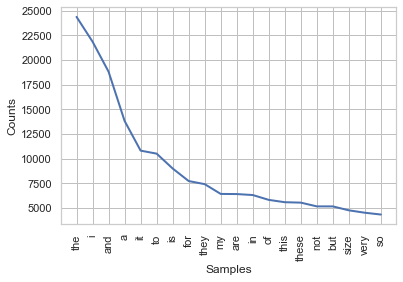

In [18]:
fdist(clean_df, "tokenized")

In [19]:
clean_df["rem_stop"] = clean_df.tokenized.apply(remove_stopwords)

Number of words in corpus: 10135


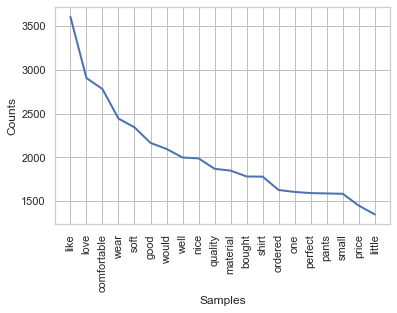

In [20]:
fdist(clean_df, "rem_stop")

In [21]:
clean_df["lemma_words"] = clean_df.rem_stop.apply(lemmatize_text)

Number of words in corpus: 9082


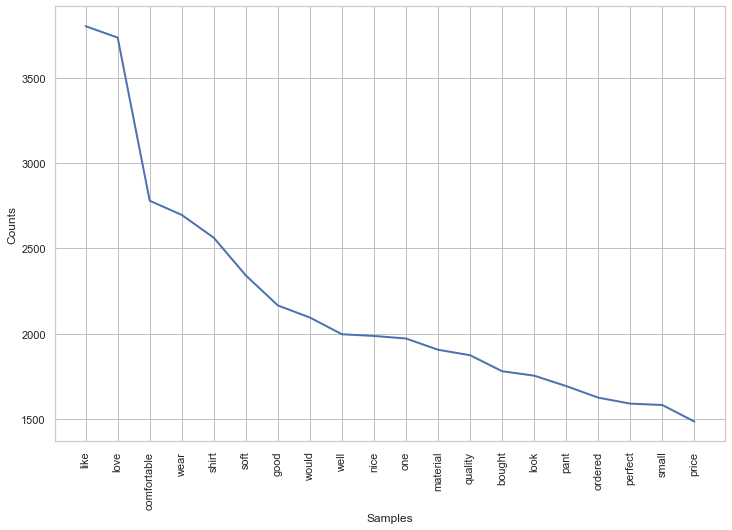

In [22]:
plt.figure(figsize=(12, 8))
fdist(clean_df, "lemma_words")


In [23]:
clean_df.head()

,item_name,price,overall_rating,num_rating,recommend,rev_title,review_text,section,target,rating_bin,clean_rev_title,clean_review_text,tokenized,rem_stop,lemma_words
0,Wrangler Men's Unlined Shirt Jacket,12.0,4.0,7.0,80.0,['Texas winter ready!'],['I bought this last year and am going to buy ...,men's clothing,0,1,texas winter ready,i bought this last year and am going to buy an...,"[i, bought, this, last, year, and, am, going, ...","[bought, last, year, going, buy, another, frid...","[bought, last, year, going, buy, another, frid..."
1,Wrangler Men's Relaxed Fit Jeans,12.0,4.5,5840.0,90.0,"['Wrangler is the best.', 'My Favorite Jeans',...","['I like wrangler, the pants is exactly for my...",men's clothing,1,1,wrangler is the best my favorite jeans extreme...,i like wrangler the pants is exactly for my bo...,"[i, like, wrangler, the, pants, is, exactly, f...","[like, wrangler, pants, exactly, body, also, g...","[like, wrangler, pant, exactly, body, also, go..."
2,Wrangler Big Men's Relaxed Fit Jean,15.0,4.3,3257.0,88.0,"['Jeans That Fit Just Right', 'Great jeans wou...","[""If you like Big Men's style wearing jeans th...",men's clothing,1,1,jeans that fit just right great jeans would bu...,if you like big men s style wearing jeans thes...,"[if, you, like, big, men, s, style, wearing, j...","[like, big, men, style, wearing, jeans, would,...","[like, big, men, style, wearing, jean, would, ..."
3,Wrangler Men's 5 Star Regular Fit Jean with Flex,12.0,4.5,259.0,91.0,"['Committed buyer', 'More Comfortable than Swe...",['My husband loves these jeans and goes throug...,men's clothing,1,1,committed buyer more comfortable than sweatpan...,my husband loves these jeans and goes through ...,"[my, husband, loves, these, jeans, and, goes, ...","[husband, loves, jeans, goes, quite, lot, thro...","[husband, love, jean, go, quite, lot, througho..."
4,Wrangler Men's and Big Men's 5 Star Relaxed Fi...,15.0,4.6,1490.0,91.0,['Saved money and faster delivery that Amazon'...,['Fit well Great price same jeans I was buying...,men's clothing,1,2,saved money and faster delivery that amazon ve...,fit well great price same jeans i was buying o...,"[fit, well, great, price, same, jeans, i, was,...","[well, price, jeans, buying, amazon, lot, less...","[well, price, jean, buying, amazon, lot, le, m..."


In [24]:
no_rec = clean_df[clean_df.target == 0]
yes_rec = clean_df[clean_df.target == 1]

In [25]:
no_rec.head(2)

,item_name,price,overall_rating,num_rating,recommend,rev_title,review_text,section,target,rating_bin,clean_rev_title,clean_review_text,tokenized,rem_stop,lemma_words
0,Wrangler Men's Unlined Shirt Jacket,12.00,4.0,7.0,80.0,['Texas winter ready!'],['I bought this last year and am going to buy ...,men's clothing,0,1,texas winter ready,i bought this last year and am going to buy an...,"[i, bought, this, last, year, and, am, going, ...","[bought, last, year, going, buy, another, frid...","[bought, last, year, going, buy, another, frid..."
10,Eddie Bauer Men's CirrusLite Down Jacket,49.98,4.4,16.0,44.0,"[""Don't Be Fooled By The Low Price"", 'Great li...","[""This jacket has REALLY impressed me. It's S...",men's clothing,0,1,don t be fooled by the low price great lightwe...,this jacket has really impressed me it s so li...,"[this, jacket, has, really, impressed, me, it,...","[jacket, really, impressed, light, like, plast...","[jacket, really, impressed, light, like, plast..."


In [26]:
text = no_rec["lemma_words"].values
text = " ".join(" ".join(word) for word in text)

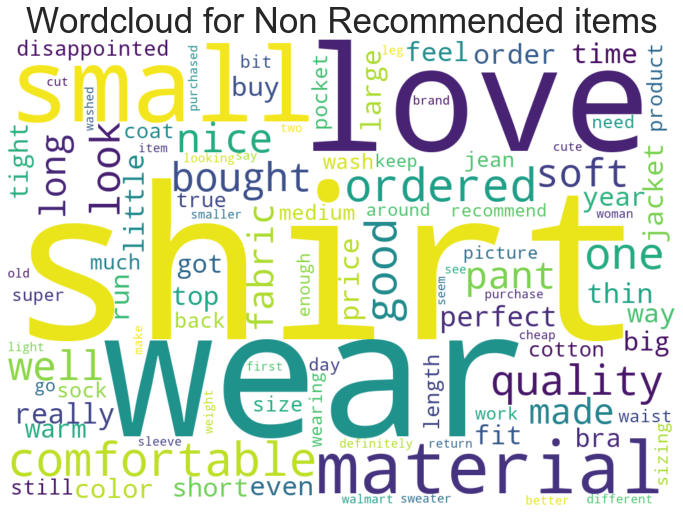

In [27]:
fig, ax = plt.subplots(figsize=(12,17))

wordcloud = WordCloud(max_words=100,collocations=False, width=1000, height=700, background_color="white", random_state=0).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud for Non Recommended items", fontsize = 35)
plt.show()

In [28]:
text =yes_rec["lemma_words"].values
text = " ".join(" ".join(word) for word in text)

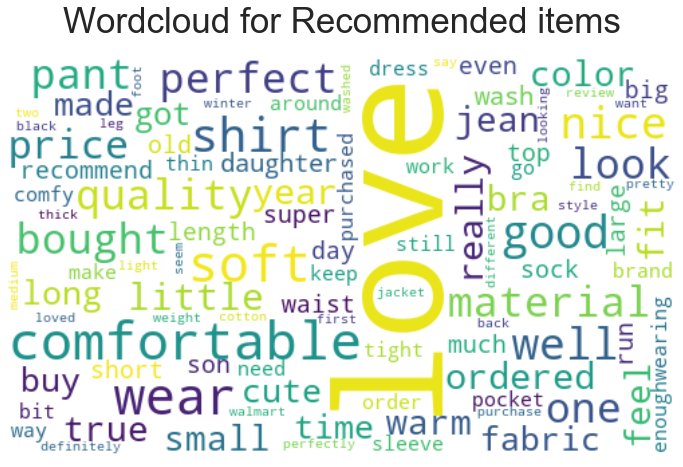

In [29]:
fig, ax = plt.subplots(figsize=(12,17))

wordcloud = WordCloud(max_words=100,collocations=False, width=500, height=300, background_color="white", random_state =0).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud for Recommended items", fontsize=35, pad=25)
plt.show()

In [30]:
clean_df.to_csv("data/sectioning_df.csv")

In [31]:
under_60 = clean_df[clean_df.recommend <=60]
over_60 = clean_df[clean_df.recommend > 60]

In [32]:
u60_text = under_60.lemma_words.values
u60_text = " ".join(" ".join(word) for word in u60_text)

o60_text = over_60.lemma_words.values
o60_text = " ".join(" ".join(word) for word in o60_text)


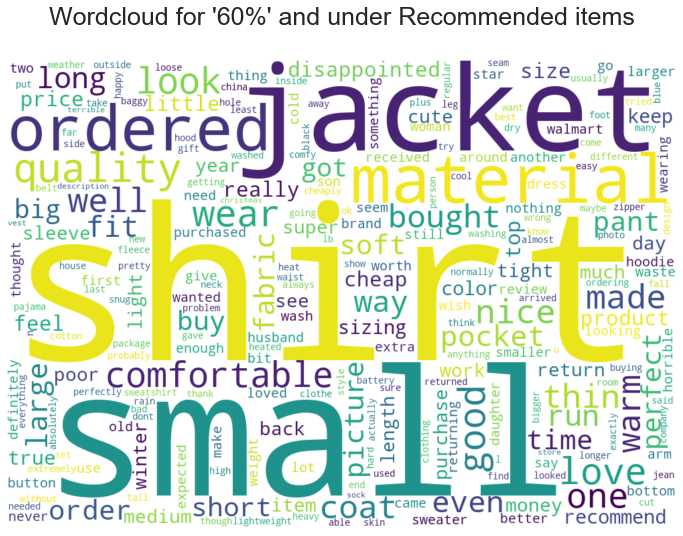

In [33]:
fig, ax = plt.subplots(figsize=(12,17))

wordcloud = WordCloud(max_words=250,collocations=False, width=1000, height=700, background_color="white", random_state=0).generate(u60_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud for '60%' and under Recommended items", fontsize=25, pad=35)
plt.show()

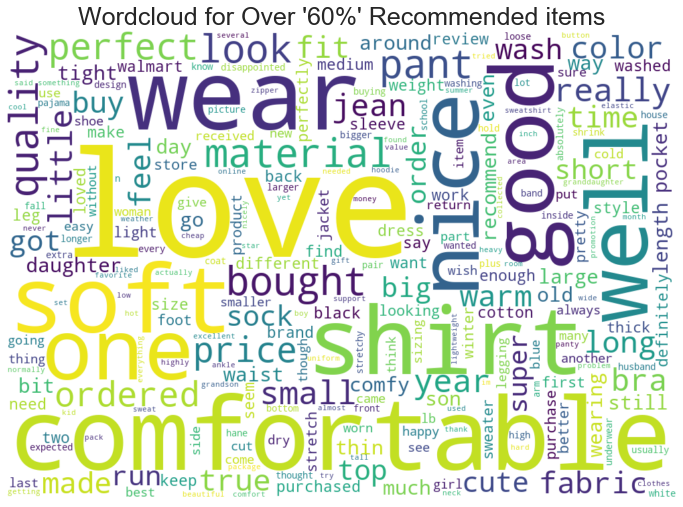

In [34]:
fig, ax = plt.subplots(figsize=(12,17))

wordcloud = WordCloud(max_words=250,collocations=False, width=1000, height=700, background_color="white", random_state=0).generate(o60_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud for Over '60%' Recommended items", fontsize = 25)
plt.show()

Adding new stopwords found from the word cloud

In [35]:
eda_stopwords = ["nd", "de", "u", "la", "tbw", "c", "v", "great", "n", "wal", "wow","hi", "hello", "nmbc", "youll", "must", "said", "either", "lol", 'ill', "six", "goat", "thou", "un", "lb", "pair", "right", "x", "xl", "one", "way", "definitely", "shirt", "jacket", "daughter", "son" ]

stop_words=list(set(stopwords.words("english")))

stop_words.extend(eda_stopwords)

In [36]:
clean_df["lemma_words"]

0       [bought, last, year, going, buy, another, frid...
1       [like, wrangler, pant, exactly, body, also, go...
2       [like, big, men, style, wearing, jean, would, ...
3       [husband, love, jean, go, quite, lot, througho...
4       [well, price, jean, buying, amazon, lot, le, m...
                              ...                        
1144    [small, way, little, average, year, old, cute,...
1145    [make, sure, go, shirt, run, small, pant, fine...
1146    [cutest, outfit, top, little, thicker, tshirt,...
1147    [nice, plush, jacket, young, girl, nice, weigh...
1148    [cute, tye, dye, awesome, sizing, little, big,...
Name: lemma_words, Length: 1149, dtype: object

In [37]:
def list_to_str(text):
    return ", ".join(text)

clean_df["delisted"] = clean_df["lemma_words"].apply(list_to_str)

### need to move below train test split. 

In [38]:
encoder = OneHotEncoder(handle_unknown="error", drop="first" )
coded_cat=pd.DataFrame(encoder.fit_transform(clean_df[["section"]]).toarray())


In [39]:
coded_cat.rename(columns={0:"girls'", 1:"men's", 2:"women's"},inplace=True)

In [40]:
frames = [clean_df, coded_cat]

In [41]:
df = pd.concat(frames, axis=1)

In [42]:
df.shape

(1149, 19)

In [43]:
interest = ["price", "overall_rating", "recommend", "rating_bin", "target"]

In [44]:
corr = df[interest].corr()

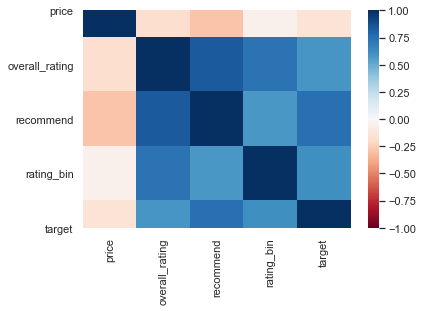

In [45]:
sns.heatmap(corr, cmap = "RdBu", vmin = -1, vmax= 1)

In [46]:
clean_df["lemma_words"] = clean_df["lemma_words"].apply(remove_stopwords)

# LDA (Topic) Model

In [47]:
import gensim

In [48]:
dataset = [d.split() for d in clean_df.delisted]
vocab = gensim.corpora.Dictionary(dataset)


In [49]:
dictionary = gensim.corpora.Dictionary(clean_df["lemma_words"])
dictionary.filter_extremes(no_above=0.5)

In [50]:
sparce_matrix = [dictionary.doc2bow(doc) for doc in clean_df["lemma_words"]]

In [51]:
tfidf = models.TfidfModel(sparce_matrix)
corpus_tfidf = tfidf[sparce_matrix]

In [52]:
%%time
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf,  num_topics=10, id2word=vocab, passes=50, workers=8, random_state=0)

CPU times: user 1min 30s, sys: 3.13 s, total: 1min 33s
Wall time: 1min 39s


In [53]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \n\Word: {}\n'.format(idx, topic))

Topic: 0 
\Word: 0.003*"weirdly," + 0.003*"sporty," + 0.001*"nowadays," + 0.000*"mixed," + 0.000*"add," + 0.000*"stronger," + 0.000*"pill," + 0.000*"sweatsuit," + 0.000*"tossed," + 0.000*"confidence,"

Topic: 1 
\Word: 0.001*"straightforward," + 0.000*"resistance," + 0.000*"travel," + 0.000*"remains," + 0.000*"choice," + 0.000*"handicap," + 0.000*"addition," + 0.000*"significantly," + 0.000*"abd," + 0.000*"arent,"

Topic: 2 
\Word: 0.002*"true" + 0.001*"avoid," + 0.001*"exception," + 0.001*"special," + 0.001*"must," + 0.001*"high," + 0.001*"many," + 0.000*"use," + 0.000*"smell," + 0.000*"refrigerated,"

Topic: 3 
\Word: 0.005*"month," + 0.004*"refrigerated," + 0.004*"grew," + 0.004*"tossed," + 0.004*"snag," + 0.003*"happens," + 0.003*"probably," + 0.003*"lazy," + 0.003*"sweatsuit," + 0.003*"preferred,"

Topic: 4 
\Word: 0.000*"crane," + 0.000*"apart," + 0.000*"sew," + 0.000*"sleeping," + 0.000*"skate," + 0.000*"rock," + 0.000*"pretty," + 0.000*"polo," + 0.000*"fishing," + 0.000*"greate

In [54]:
corpus_transformed = lda_model_tfidf[sparce_matrix]

In [55]:
%%time
# convert to dataframe
topics = [dict(x) for x in corpus_transformed]

# convert list of lda topic weights to dataframe
lda_tfidf_df = pd.DataFrame(topics)
# rename columns
lda_tfidf_df.rename(columns={i: f'topic{i}' for i in range(10)}, inplace=True)

lda_tfidf_df.fillna(0, inplace=True)

CPU times: user 185 ms, sys: 4.88 ms, total: 190 ms
Wall time: 191 ms


In [56]:
lda_tfidf_df

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,0.011114,0.011114,0.011114,0.899972,0.011114,0.011114,0.011114,0.011114,0.011114,0.011114
1,0.000000,0.000000,0.000000,0.998047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.997686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.996085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.997280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1144,0.012501,0.012501,0.012501,0.887487,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501
1145,0.000000,0.000000,0.000000,0.954993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1146,0.000000,0.000000,0.000000,0.981628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1147,0.000000,0.000000,0.000000,0.989652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [57]:
frames = [df, lda_tfidf_df]
df = pd.concat(frames, axis=1)

In [58]:
df.shape

(1149, 29)

In [59]:
df.iloc[:,19:29]

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,0.011114,0.011114,0.011114,0.899972,0.011114,0.011114,0.011114,0.011114,0.011114,0.011114
1,0.000000,0.000000,0.000000,0.998047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.997686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.996085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.997280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1144,0.012501,0.012501,0.012501,0.887487,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501
1145,0.000000,0.000000,0.000000,0.954993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1146,0.000000,0.000000,0.000000,0.981628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1147,0.000000,0.000000,0.000000,0.989652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [60]:
df.head()

,item_name,price,overall_rating,num_rating,recommend,rev_title,review_text,section,target,rating_bin,clean_rev_title,clean_review_text,tokenized,rem_stop,lemma_words,delisted,girls',men's,women's,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,Wrangler Men's Unlined Shirt Jacket,12.0,4.0,7.0,80.0,['Texas winter ready!'],['I bought this last year and am going to buy ...,men's clothing,0,1,texas winter ready,i bought this last year and am going to buy an...,"[i, bought, this, last, year, and, am, going, ...","[bought, last, year, going, buy, another, frid...","[bought, last, year, going, buy, another, frid...","bought, last, year, going, buy, another, frida...",0.0,1.0,0.0,0.011114,0.011114,0.011114,0.899972,0.011114,0.011114,0.011114,0.011114,0.011114,0.011114
1,Wrangler Men's Relaxed Fit Jeans,12.0,4.5,5840.0,90.0,"['Wrangler is the best.', 'My Favorite Jeans',...","['I like wrangler, the pants is exactly for my...",men's clothing,1,1,wrangler is the best my favorite jeans extreme...,i like wrangler the pants is exactly for my bo...,"[i, like, wrangler, the, pants, is, exactly, f...","[like, wrangler, pants, exactly, body, also, g...","[like, wrangler, pant, exactly, body, also, go...","like, wrangler, pant, exactly, body, also, goo...",0.0,1.0,0.0,0.000000,0.000000,0.000000,0.998047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Wrangler Big Men's Relaxed Fit Jean,15.0,4.3,3257.0,88.0,"['Jeans That Fit Just Right', 'Great jeans wou...","[""If you like Big Men's style wearing jeans th...",men's clothing,1,1,jeans that fit just right great jeans would bu...,if you like big men s style wearing jeans thes...,"[if, you, like, big, men, s, style, wearing, j...","[like, big, men, style, wearing, jeans, would,...","[like, big, men, style, wearing, jean, would, ...","like, big, men, style, wearing, jean, would, r...",0.0,1.0,0.0,0.000000,0.000000,0.000000,0.997686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Wrangler Men's 5 Star Regular Fit Jean with Flex,12.0,4.5,259.0,91.0,"['Committed buyer', 'More Comfortable than Swe...",['My husband loves these jeans and goes throug...,men's clothing,1,1,committed buyer more comfortable than sweatpan...,my husband loves these jeans and goes through ...,"[my, husband, loves, these, jeans, and, goes, ...","[husband, loves, jeans, goes, quite, lot, thro...","[husband, love, jean, go, quite, lot, througho...","husband, love, jean, go, quite, lot, throughou...",0.0,1.0,0.0,0.000000,0.000000,0.000000,0.996085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Wrangler Men's and Big Men's 5 Star Relaxed Fi...,15.0,4.6,1490.0,91.0,['Saved money and faster delivery that Amazon'...,['Fit well Great price same jeans I was buying...,men's clothing,1,2,saved money and faster delivery that amazon ve...,fit well great price same jeans i was buying o...,"[fit, well, great, price, same, jeans, i, was,...","[well, price, jeans, buying, amazon, lot, less...","[well, price, jean, buying, amazon, lot, le, m...","well, price, jean, buying, amazon, lot, le, mo...",0.0,1.0,0.0,0.000000,0.000000,0.000000,0.997280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [61]:
import pickle

In [62]:
filename = "data/modeling_df.pkl"
outfile = open(filename, "wb")

In [63]:
pickle.dump(df,outfile)
outfile.close

<function BufferedWriter.close>